In [1]:
using DataFrames, FileIO, DelimitedFiles
using Plots, Optim, LsqFit

In [2]:
# Get ready
home = "/home/pbarletta/labo/20/cph_obp/"
apo_cph_out = string(home, "run/apo/pdt/cph_outputs/")
apo_cph_pre_out = string(home, "run/apo/pre_pdt/cph_outputs/")

phs = collect(30:5:75)
suffix_pka_file = "_pka"
suffix_pop_file = "_pop"
titrable_cnt = 36

global const def_pka_as4 = 3.71
global const def_pka_gl4 = 4.15
global const def_pka_lys = 10.67
global const def_pka_hip = 6.04;
# global const def_pka_cyx = 8.14;
# global const def_pka_tyr = 10.1;

## Leo los \_pop files

In [3]:
# Obtengo las poblaciones deprotonadas de c/ residuo a c/ valor de pH
# Leo el State 0 de c/ residuo. P/ los residuos ácidos (GL4, AS4)
# el state 0 es deprotonado, p/ los básicos es protonado.
# Usaré estas poblaciones p/ ajustar la curva de Hill y obtener el valor de pKa.

deprotonated_fraction = Array{Float64, 2}(undef, titrable_cnt, length(phs));
i = 0
for ph in phs
    i+=1
    pop_filename = string(apo_cph_pre_out, ph, suffix_pop_file)
    pop_file = readdlm(pop_filename, header = true)[1][2:end, 2:end]
    if i == 1
        global titrable_resnames = convert(Array{String}, pop_file[:, 1]) # const
        global titrable_resis = convert(Array{Int64}, pop_file[:, 2]) # const
    end

    k = 0
    for resname in titrable_resnames
        k+=1
        if resname == "GL4"
            deprotonated_fraction[k, i] = pop_file[k, 3:end][1]
        elseif resname == "AS4"
            deprotonated_fraction[k, i] = pop_file[k, 3:end][1]
        elseif resname == "HIP"
            deprotonated_fraction[k, i] = 1 - pop_file[k, 3:end][1]
        elseif resname == "LYS"
            deprotonated_fraction[k, i] = 1 - pop_file[k, 3:end][1]
        end
    end            
end

## Leo los \_pka files

In [4]:
# P/ ajustar bien la curva de Hill y obtener los parámetros n y pKa conviene
# empezar con unos buenos parámetros iniciales. P/ n eso es 1.0 y p/ pKa será
# el valor de pKa predicho durante la corrida con menor Offset. Por eso leo
# estos archivos de _pka, p/ obtener los pka predichos y sólo usar el q venga
# con de la corrida con menor offset. Cualquier cosa: ver papers de Swails.

res_offset_all = Array{Float64, 2}(undef, titrable_cnt, length(phs))
res_pka_pred_all = Array{Float64, 2}(undef, titrable_cnt, length(phs))
res_pka_pred =  Array{Float64, 1}(undef, titrable_cnt)

for i = 1:length(phs)
    pka_file = readdlm(string(apo_cph_pre_out, phs[i], suffix_pka_file),
        header = true)[1][1:end-1, 1:end-1]    
    res_offset_all[:, i] = pka_file[:, 5]
    res_pka_pred_all[:, i] = pka_file[:, 7]
end

for i = 1:titrable_cnt
    min_offset_idx = findmin(abs.(res_offset_all[i, :]))[2]
    res_pka_pred[i] = res_pka_pred_all[i, min_offset_idx]
end

## Determino Hill coefficients and pKas

In [5]:
# Hill coefficient and pKa for each residue 
res_pka =  Array{Tuple{Float64, Float64}, 1}(undef, titrable_cnt)

# Hill function
@. f(x, hill_coef) = 1 / (1 + 10 ^(hill_coef[1]*(hill_coef[2] - x)) )
xdata = phs ./ 10

# Fit the curves
for i = 1:titrable_cnt
    hill_coef = [1. ; res_pka_pred[i]]
    fit = curve_fit(f, xdata, deprotonated_fraction[i, :], hill_coef)    
    res_pka[i] = (fit.param[1], fit.param[2])
end

# Guardo los pkas obtenidos
# writetable(string(home, "rtdos_log/pka_apo"), df_titrable_apo, separator = '\t');

In [6]:
function titration_curve(n, pKa, x)
    return (1 / (1 + 10 ^(n*(pKa - x))))
end
x = collect(1:.1:14);

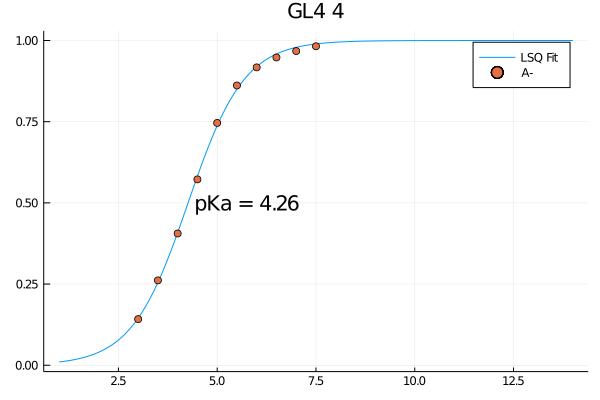

In [7]:
i = 1
plot(x, titration_curve.(res_pka[i][1], res_pka[i][2], x),
    label = "LSQ Fit",
    title = string(titrable_resnames[i], " ", titrable_resis[i]))

scatter!(xdata, deprotonated_fraction[i, :],
    label = "A-")

annotate!((res_pka[i][2] + 1.5), .5, 
    Plots.text(string("pKa = ", round(res_pka[i][2], digits = 2))))

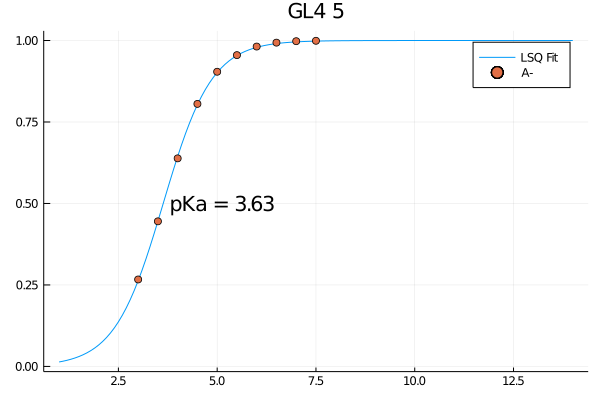

In [8]:
i = 2
plot(x, titration_curve.(res_pka[i][1], res_pka[i][2], x),
    label = "LSQ Fit",
    title = string(titrable_resnames[i], " ", titrable_resis[i]))

scatter!(xdata, deprotonated_fraction[i, :],
    label = "A-")

annotate!((res_pka[i][2] + 1.5), .5, 
    Plots.text(string("pKa = ", round(res_pka[i][2], digits = 2))))

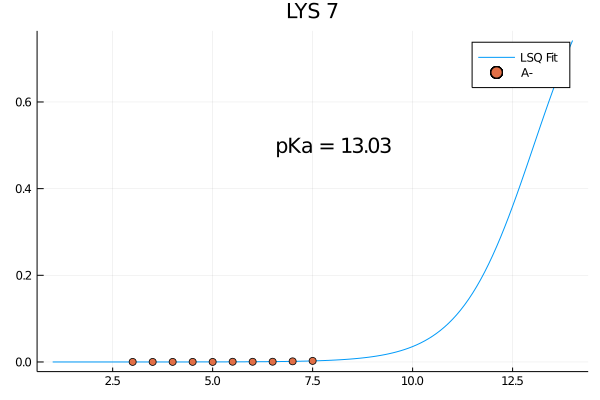

In [9]:
i = 3
plot(x, titration_curve.(res_pka[i][1], res_pka[i][2], x),
    label = "LSQ Fit",
    title = string(titrable_resnames[i], " ", titrable_resis[i]))

scatter!(xdata, deprotonated_fraction[i, :],
    label = "A-")

annotate!((res_pka[i][2] - 5.), .5, 
    Plots.text(string("pKa = ", round(res_pka[i][2], digits = 2))))

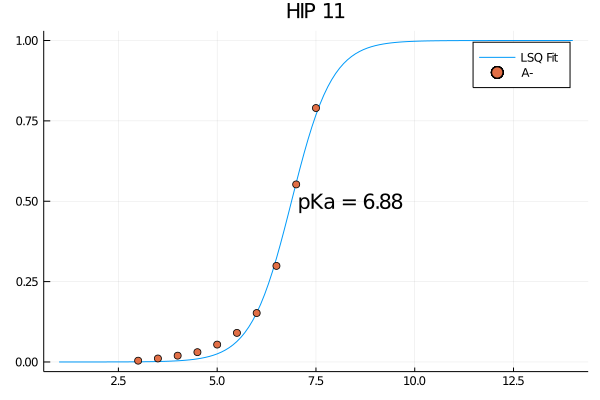

In [10]:
i = 4
plot(x, titration_curve.(res_pka[i][1], res_pka[i][2], x),
    label = "LSQ Fit",
    title = string(titrable_resnames[i], " ", titrable_resis[i]))

scatter!(xdata, deprotonated_fraction[i, :],
    label = "A-")

annotate!((res_pka[i][2] + 1.5), .5, 
    Plots.text(string("pKa = ", round(res_pka[i][2], digits = 2))))

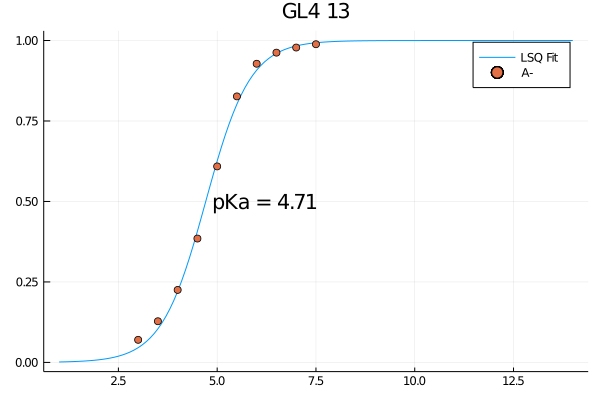

In [11]:
i = 5
plot(x, titration_curve.(res_pka[i][1], res_pka[i][2], x),
    label = "LSQ Fit",
    title = string(titrable_resnames[i], " ", titrable_resis[i]))

scatter!(xdata, deprotonated_fraction[i, :],
    label = "A-")

annotate!((res_pka[i][2] + 1.5), .5, 
    Plots.text(string("pKa = ", round(res_pka[i][2], digits = 2))))

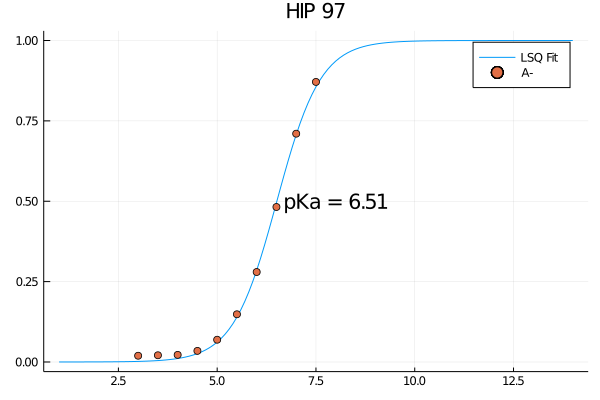

In [12]:
i = 30
plot(x, titration_curve.(res_pka[i][1], res_pka[i][2], x),
    label = "LSQ Fit",
    title = string(titrable_resnames[i], " ", titrable_resis[i]))

scatter!(xdata, deprotonated_fraction[i, :],
    label = "A-")

annotate!((res_pka[i][2] + 1.5), .5, 
    Plots.text(string("pKa = ", round(res_pka[i][2], digits = 2))))